In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import optuna
import matplotlib.pyplot as plt

## Цель работы

Разработка и исследование модели Хольта-Уинтерса для прогнозирования временных рядов с трендом и сезонностью. Выполнение автоматической настройки гиперпараметров модели с использованием алгоритмов машинного обучения для повышения точности прогнозирования.

## Постановка задачи

1.  **Реализовать на языке программирования Python модель Хольта-Уинтерса** без использования готовых библиотечных реализаций. Модель должна корректно обрабатывать временные ряды с аддитивной сезонностью и трендом.
2.  **Создать два режима работы программы:**
    * **Обычный режим:** Принимает на вход временной ряд, заданные пользователем параметры сглаживания ($\alpha$, $\beta$, $\tau$), длину сезона ($s$), и горизонт прогнозирования ($h$, равный 1 или 2). На выходе предоставляет значения параметров модели (последние оценки уровня и тренда), последние значения сезонных коэффициентов и прогнозные значения.
    * **Режим тюнинга гиперпараметров:** Использует алгоритмы машинного обучения (например, на основе библиотеки `optuna`) для автоматического поиска оптимальных значений параметров сглаживания ($\alpha$, $\beta$, $\tau$). Опционально реализовать тюнинг длины сезона ($s$). На выходе предоставляет оптимальные значения гиперпараметров (и длины сезона, если она подбиралась), а также параметры обученной модели с этими гиперпараметрами и прогнозные значения.
3.  **Обеспечить четкую и структурированную выдачу результатов** в обоих режимах работы.

## Краткое описание модели Хольта-Уинтерса

Модель Хольта-Уинтерса является методом экспоненциального сглаживания, применяемым для прогнозирования временных рядов, которые демонстрируют как тренд, так и сезонность. Модель основана на трех уравнениях сглаживания, которые обновляют уровень, тренд и сезонную компоненту временного ряда с течением времени:

* **Уровень ($l_t$)**: Оценка уровня ряда в момент времени $t$. Обновляется с учетом текущего наблюдения, скорректированного на сезонность, и предыдущей оценки уровня с учетом тренда.
    $$l_t = \alpha (y_t - s_{t-s}) + (1 - \alpha) (l_{t-1} + b_{t-1})$$
    где $y_t$ - фактическое значение в момент $t$, $s_{t-s}$ - сезонная компонента в момент $t-s$, $\alpha$ - параметр сглаживания уровня ($0 \le \alpha \le 1$), $b_{t-1}$ - оценка тренда в момент $t-1$.

* **Тренд ($b_t$)**: Оценка наклона тренда в момент времени $t$. Обновляется с учетом изменения уровня между текущим и предыдущим периодами и предыдущей оценки тренда.
    $$b_t = \beta (l_t - l_{t-1}) + (1 - \beta) b_{t-1}$$
    где $\beta$ - параметр сглаживания тренда ($0 \le \beta \le 1$).

* **Сезонность ($s_t$)**: Оценка сезонной компоненты в момент времени $t$. Обновляется с учетом отклонения текущего наблюдения от уровня и предыдущей сезонной компоненты для того же периода сезона.
    $$s_t = \tau (y_t - l_t) + (1 - \tau) s_{t-s}$$
    где $\tau$ - параметр сглаживания сезонности ($0 \le \tau \le 1$), $s$ - длина сезона.

Прогноз на $h$ периодов вперед ($\hat{y}_{t+h}$) осуществляется по формуле:
$$\hat{y}_{t+h} = l_t + h \cdot b_t + s_{t+h-s}$$

Параметры сглаживания ($\alpha$, $\beta$, $\tau$) определяют вес, придаваемый последним наблюдениям при обновлении компонент модели. Их оптимальные значения могут быть найдены с помощью методов оптимизации, минимизирующих ошибку прогноза на исторических данных.

## Ход работы

Создаем класс модели, определяем методы класса

In [194]:
class HoltWinters:
    def __init__(self, series, slen, alpha, beta, tau, initial_level=None, initial_trend=None, initial_seasonal=None):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.initial_level = initial_level
        self.initial_trend = initial_trend
        self.initial_seasonal = initial_seasonal
        self.level = None
        self.trend = None
        self.seasonal = None
        self.predictions = None

    def _initialization(self):
        n = len(self.series)
        if self.initial_level is None:
            self.initial_level = self.series[0]
        if self.initial_trend is None:
            self.initial_trend = (self.series[self.slen] - self.series[0]) / self.slen
        if self.initial_seasonal is None:
            self.initial_seasonal = [self.series[i] - self.initial_level - i * self.initial_trend for i in range(self.slen)]
        self.level = [self.initial_level]
        self.trend = [self.initial_trend]
        self.seasonal = list(self.initial_seasonal)

    def fit(self):
        self._initialization()
        n = len(self.series)
        self.predictions = [None] * n

        for i in range(n):
            if i < self.slen:
                continue

            level_prev = self.level[-1]
            trend_prev = self.trend[-1]
            seasonal_prev = self.seasonal[i - self.slen]

            level = self.alpha * (self.series[i] - seasonal_prev) + (1 - self.alpha) * (level_prev + trend_prev)
            trend = self.beta * (level - level_prev) + (1 - self.beta) * trend_prev
            seasonal = self.tau * (self.series[i] - level) + (1 - self.tau) * seasonal_prev
            prediction = level_prev + trend_prev + seasonal_prev

            self.level.append(level)
            self.trend.append(trend)
            self.seasonal.append(seasonal)
            self.predictions[i] = prediction

        self.level = self.level[1:]
        self.trend = self.trend[1:]
        self.seasonal = self.seasonal[self.slen:]

    def predict(self, h):
        if self.predictions is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод fit().")

        forecast = []
        last_level = self.level[-1]
        last_trend = self.trend[-1]
        seasonal_history = self.seasonal[-self.slen:]

        for i in range(h):
            seasonal_index = i % self.slen
            forecast_value = last_level + (i + 1) * last_trend + seasonal_history[seasonal_index]
            forecast.append(forecast_value)

        return np.array(forecast)

Создаем ЦФ, чтобы реализовать оптимизацию гиперпараметров

In [206]:
def objective(trial, train, test, h):
    alpha = trial.suggest_float("alpha", 0, 1)
    beta = trial.suggest_float("beta", 0, 1)
    tau = trial.suggest_float("tau", 0, 1)
    model = HoltWinters(train, 365, alpha, beta, tau)
    model.fit()
    predictions = model.predict(len(test))
    mse = mean_squared_error(test, predictions)
    return mse

Создаем функцию для тюнинга гиперпараметров модели, я решил использовать optuna

In [208]:
def tune_hyperparameters_optuna(train, test, h, n_trials=100):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, train, test, h), n_trials=n_trials)

    best_params = study.best_params
    return best_params

## Датасет

Датасет температуры в Мумбае за 2016-2020 гг.


In [88]:
df = pd.read_csv('rainfall.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y')
df

,datetime,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
0,2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0
1,2016-01-02,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0
2,2016-01-03,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0
3,2016-01-04,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0
4,2016-01-05,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0
...,...,...,...,...,...,...,...,...,...,...
1776,2020-11-11,27.4,12.2,41.5,1011.8,108.3,220.4,17.2,0,0
1777,2020-11-12,28.0,13.0,40.9,1012.6,148.4,225.1,16.6,0,0
1778,2020-11-13,28.4,18.7,56.9,1011.9,131.8,223.4,18.4,0,0
1779,2020-11-14,29.5,20.9,61.3,1010.2,154.2,232.7,19.3,0,0


In [119]:
df_temp = df[['datetime', 'temp']]
df_temp = df_temp['temp']
df_temp

0       28.4
1       26.8
2       25.5
3       26.4
4       27.1
        ... 
1776    27.4
1777    28.0
1778    28.4
1779    29.5
1780    29.7
Name: temp, Length: 1781, dtype: float64

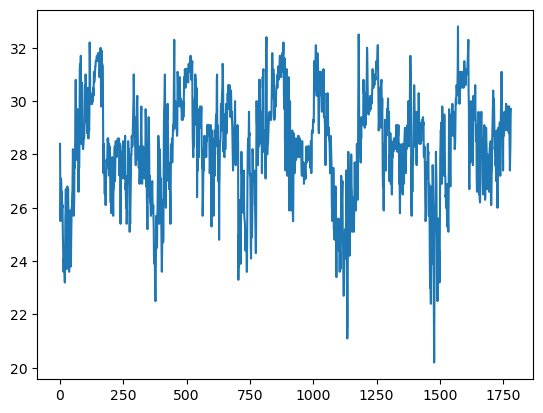

In [125]:
plt.plot(df_temp)

Из графика видно - что длина сезона составляет количество дней в году - 365 (Что в целом логично, ведь это температура)

In [200]:
seasonal_length = 365

# Разделение на обучающую и тестовую выборки
train_size = int(len(df_temp) * 0.8)
train_data = df_temp[:train_size]
test_data = df_temp[train_size:]
forecast_horizon = 2

In [202]:
print("--- Обычный режим ---")
alpha_m = 0.3
beta_m = 0.1
tau_m = 0.6

model_m = HoltWinters(train_data, seasonal_length, alpha_m, beta_m, tau_m)
model_m.fit()
forecast_m = model_m.predict(forecast_horizon)

print("Параметры модели (обычный режим):")
print(f"  Коэффициент уровня (последний): {model_m.level[-1]:.4f}")
print(f"  Коэффициент тренда (последний): {model_m.trend[-1]:.4f}")
print("Прогнозные значения (обычный режим):", forecast_m)

--- Обычный режим ---
Параметры модели (обычный режим):
  Коэффициент уровня (последний): 27.3424
  Коэффициент тренда (последний): -0.0203
Прогнозные значения (обычный режим): [28.16909199 28.39944972]


## Тюнинг гиперпараметров

In [210]:
print("\n--- Режим тюнинга гиперпараметров ---")
opt_params = tune_hyperparameters_optuna(train_data, test_data, forecast_horizon, n_trials=50)

[I 2025-05-12 20:41:03,893] A new study created in memory with name: no-name-1532ea1c-6fb4-4cdb-a54c-16a32a759b43
[I 2025-05-12 20:41:03,900] Trial 0 finished with value: 190.08910133694818 and parameters: {'alpha': 0.3039769974147136, 'beta': 0.1241667182961963, 'tau': 0.7599601733429813}. Best is trial 0 with value: 190.08910133694818.
[I 2025-05-12 20:41:03,909] Trial 1 finished with value: 43379.03796002423 and parameters: {'alpha': 0.6621714539648678, 'beta': 0.9294947150987344, 'tau': 0.9864047279288966}. Best is trial 0 with value: 190.08910133694818.
[I 2025-05-12 20:41:03,916] Trial 2 finished with value: 17976.988638497758 and parameters: {'alpha': 0.9018199913777727, 'beta': 0.7996935470179136, 'tau': 0.4554246421389142}. Best is trial 0 with value: 190.08910133694818.
[I 2025-05-12 20:41:03,924] Trial 3 finished with value: 4388.312530481593 and parameters: {'alpha': 0.24247739115298073, 'beta': 0.4706889616461174, 'tau': 0.7935440311163835}. Best is trial 0 with value: 190


--- Режим тюнинга гиперпараметров ---


[I 2025-05-12 20:41:04,085] Trial 15 finished with value: 47.29536257608648 and parameters: {'alpha': 0.6838393452352463, 'beta': 0.15911612325802485, 'tau': 0.25702170284747106}. Best is trial 13 with value: 2.9827432035985195.
[I 2025-05-12 20:41:04,105] Trial 16 finished with value: 2.9976274658394426 and parameters: {'alpha': 0.43899262951145623, 'beta': 0.005478528319582605, 'tau': 0.1332943696279076}. Best is trial 13 with value: 2.9827432035985195.
[I 2025-05-12 20:41:04,125] Trial 17 finished with value: 1722.6034938165826 and parameters: {'alpha': 0.40804206290370404, 'beta': 0.34335592879042887, 'tau': 0.34897383779622626}. Best is trial 13 with value: 2.9827432035985195.
[I 2025-05-12 20:41:04,142] Trial 18 finished with value: 1302.9325589980103 and parameters: {'alpha': 0.7955845093144306, 'beta': 0.30715004802851875, 'tau': 0.3701484539409898}. Best is trial 13 with value: 2.9827432035985195.
[I 2025-05-12 20:41:04,162] Trial 19 finished with value: 6.477716153877848 and 

In [212]:
print("\nОптимальные параметры (найденные с помощью Optuna):")
print(f"  Альфа: {opt_params['alpha']:.4f}")
print(f"  Бета: {opt_params['beta']:.4f}")
print(f"  Тау: {opt_params['tau']:.4f}")


Оптимальные параметры (найденные с помощью Optuna):
  Альфа: 0.5912
  Бета: 0.0046
  Тау: 0.2580


In [214]:
model_tuned = HoltWinters(train_data, seasonal_length,
                              opt_params['alpha'], opt_params['beta'], opt_params['tau'])
model_tuned.fit()
forecast_tuned = model_tuned.predict(forecast_horizon)

print("\nПараметры модели (режим тюнинга):")
print(f"  Коэффициент уровня (последний): {model_tuned.level[-1]:.4f}")
print(f"  Коэффициент тренда (последний): {model_tuned.trend[-1]:.4f}")


Параметры модели (режим тюнинга):
  Коэффициент уровня (последний): 27.5489
  Коэффициент тренда (последний): -0.0001


## Оценка на тестовых данных

In [216]:
forecast_horizon_plot = len(test_data)
model_full = HoltWinters(train_data, seasonal_length,
                              opt_params['alpha'], opt_params['beta'], opt_params['tau'])
model_full.fit()
forecast_tuned = model_tuned.predict(forecast_horizon_plot)
forecast_series_tuned = pd.Series(forecast_tuned, index=test_data.index)
mse = mean_squared_error(test_data, predictions_test)
print(f"\nСреднеквадратическая ошибка на тестовых данных (с тюнингом): {mse:.4f}")


Среднеквадратическая ошибка на тестовых данных (с тюнингом): 4.0042


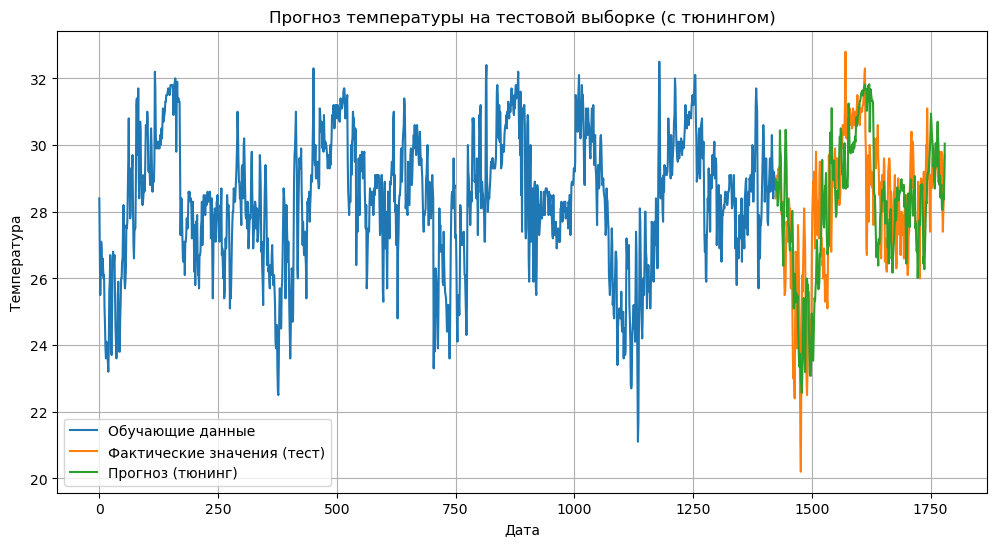

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Обучающие данные')
plt.plot(test_data, label='Фактические значения (тест)')
plt.plot(forecast_series_tuned, label='Прогноз (тюнинг)')
plt.title('Прогноз температуры на тестовой выборке (с тюнингом)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.grid(True)
plt.show()

Markdown

## Выводы по результатам работы с моделью Хольта-Уинтерса и тюнингом гиперпараметров

На основе проведенного анализа и полученных результатов можно сделать следующие выводы:

**1. Оптимизированные параметры сглаживания:**

* **Альфа (α = 0.5912):** Значение альфа около 0.6 указывает на то, что модель придает умеренный вес как последним наблюдениям, так и предыдущей оценке уровня.
* **Бета (β = 0.0046):** Значение бета очень близко к 0 свидетельствует о том, что оценка тренда практически не обновляется. Модель считает тренд стабильным, что видно и по малому значению последнего коэффициента тренда.
* **Тау (γ = 0.2580):** Значение тау (параметра сглаживания сезонности) показывает, что модель придает умеренный вес последним наблюдаемым сезонным отклонениям при обновлении сезонной компоненты.

**2. Параметры модели после обучения с оптимальными гиперпараметрами:**

* **Коэффициент уровня (последний): 27.5489:** Это последняя оценка базового уровня температуры временного ряда на момент окончания обучающих данных.
* **Коэффициент тренда (последний): -0.0001:** Последняя оценка тренда очень близка к нулю, что подтверждает стабильность тренда. Небольшое отрицательное значение предполагает незначительное понижение температуры в долгосрочной перспективе, но его величина крайне мала.


**Визуализация прогнозов:**

* График показывает, что модель в целом улавливает общую динамику температурного ряда на тестовой выборке. Видны сезонные колебания в прогнозах, соответствующие фактическим изменениям.
* Однако наблюдаются и расхождения между прогнозом и фактическими значениями. В некоторые периоды модель может недооценивать или переоценивать температуру.
* Амплитуда сезонных колебаний в прогнозе может отличаться от амплитуды фактических значений.

**Общие выводы:**

* Тюнинг гиперпараметров с помощью Optuna позволил найти оптимальную комбинацию параметров сглаживания ($\alpha$, $\beta$, $\tau$) для модели Хольта-Уинтерса на данном временном ряду.
* Полученная модель демонстрирует способность отслеживать уровень и сезонность температурных данных, при этом предполагая относительно стабильный тренд.
* Значение MSE предоставляет количественную оценку точности прогнозов.
* Визуализация подтверждает, что модель улавливает основные паттерны, но имеет room for improvement в точности краткосрочных прогнозов и амплитуде сезонных колебаний.
